In [2]:
import numpy as np
import pandas as pd
from google.cloud import bigquery

import seaborn as sns 
import matplotlib.pyplot as plt 

In [2]:
bq_client = bigquery.Client(
    project='prj-vo-aa-p-data-science-exp', 
    location='europe-west2')

# Plot setup

In [4]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(16,6),
    titlesize=12,
    titleweight="bold",
)

plt.rc(
    "axes",
    labelweight="bold",
    labelsize=12,
    titleweight="bold",
    titlesize=12,
    titlepad=10,
)

plt.rc(
    "legend",
    fontsize=12
)

plot_params = dict(
    color="0.75",
    style="._",
    markeredgecolor="0.25",
    marketfacecolor="0.25",
    legend=True
)

/var/folders/pq/1pygt1_j2fn4w2qq_zh70bdh0000gp/T/ipykernel_85998/3821752008.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


# By postcode and treatment

In [5]:
query = """

WITH 
regions AS (

  SELECT 
    postcode, 
    town, 
    local_authority,
    region
  FROM `prj-vo-aa-p-cdh-prod.geography.geography_postcode` 

),

postcodes AS (

    SELECT
        icoms_id.icoms_premises_uid,
        premises_location.postcode,
    FROM
        `prj-vo-aa-p-data-modellin-prod.data_modelling_base.premises_details_base` 

),

sales AS (

SELECT DISTINCT
  date AS transaction_date,
  (
    SELECT value
    FROM UNNEST(hit.customDimensions)
    WHERE index = 41
  ) AS premise_uid,
  LOWER(product.v2ProductCategory) AS productCategory,

FROM
  `prj-vm-p-ga360-landing.vmdata_ga360_landing.ga_sessions_*` AS session,
  UNNEST(session.hits) AS hit
  LEFT JOIN UNNEST(hit.product) AS product
  LEFT JOIN UNNEST(product.customDimensions) AS customDimensions

WHERE
  _TABLE_SUFFIX BETWEEN '20230101' AND '20231231'
  AND (
    SELECT value
    FROM UNNEST(hit.customDimensions)
    WHERE index = 35
  ) LIKE '%new_cable_order%'
  AND hit.transaction.transactionId is not null 

),

sales_by_postcode AS (

  SELECT 
    postcode,
    count(*) AS num_sales

  FROM sales s
    LEFT JOIN postcodes p 
    ON s.premise_uid = CAST(p.icoms_premises_uid AS STRING)
    GROUP BY 1

),

postcode_level AS (

SELECT
  p.postcode,
  REGEXP_EXTRACT(p.postcode, r'^(.*?)\s') AS outcode,
  p.households,
  p.treatment,

  r.town,
  r.local_authority,
  r.region,

  COALESCE(sales.num_sales, 0) AS num_sales

FROM `prj-vo-aa-p-data-science-exp.m7914180.rnba-1252-postcode-pricing-group-allocations` p

LEFT JOIN regions r 
  ON p.postcode = r.postcode

LEFT JOIN sales_by_postcode sales 
  ON p.postcode = sales.postcode

),

outcode_level AS (

  SELECT 
    outcode,
    SUM(households) AS num_households,
    SUM(num_sales) AS num_sales

  FROM postcode_level
  GROUP BY outcode 

)


SELECT *
FROM postcode_level

"""

experiment = bq_client.query(query).to_dataframe()
experiment.shape

(261047, 8)

In [6]:
experiment

postcode outcode  households              treatment            town  \
0       CH66 2QU    CH66          10      overbuild_control  Ellesmere Port   
1       CV22 7LY    CV22          10      overbuild_control           Rugby   
2       DN41 7JP    DN41          10      overbuild_control         Healing   
3        E17 3DJ     E17          10      overbuild_control     Walthamstow   
4        KA7 2NH     KA7          10      overbuild_control             Ayr   
...          ...     ...         ...                    ...             ...   
261042  BH18 9LF    BH18          37  non_overbuild_control           Poole   
261043  BH10 4DP    BH10          40     overbuild_variant1     Bournemouth   
261044  BH17 7JJ    BH17          42  non_overbuild_control           Poole   
261045   BH4 9HS     BH4          55     overbuild_variant1     Bournemouth   
261046   BH1 4ES     BH1          65      overbuild_control     Bournemouth   

                            local_authority                       region  \
0                 Cheshire West and Chester                   North West   
1                                     Rugby                West Midlands   
2                   North East Lincolnshire  Yorkshire and East Midlands   
3                            Waltham Forest               Greater London   
4                            South Ayrshire      Scotland and North East   
...                                     ...                          ...   
261042  Bournemouth, Christchurch and Poole                  South Coast   
261043  Bournemouth, Christchurch and Poole                  South Coast   
261044  Bournemouth, Christchurch and Poole                  South Coast   
261045  Bournemouth, Christchurch and Poole                  South Coast   
261046  Bournemouth, Christchurch and Poole                  South Coast   

        num_sales  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
261042          0  
261043          4  
261044          1  
261045          0  
261046          6  

[261047 rows x 8 columns]

# By week and treatment



In [7]:
by_week_and_treatment_query = """ 

WITH 

postcodes AS (

    SELECT
        icoms_id.icoms_premises_uid,
        premises_location.postcode,
    FROM
        `prj-vo-aa-p-data-modellin-prod.data_modelling_base.premises_details_base` 

),

sales AS (

SELECT DISTINCT
 
  PARSE_DATE('%Y%m%d', date) AS sale_date,

  (
    SELECT value
    FROM UNNEST(hit.customDimensions)
    WHERE index = 41
  ) AS premise_uid,
  LOWER(product.v2ProductCategory) AS productCategory,

FROM
  `prj-vm-p-ga360-landing.vmdata_ga360_landing.ga_sessions_*` AS session,
  UNNEST(session.hits) AS hit
  LEFT JOIN UNNEST(hit.product) AS product
  LEFT JOIN UNNEST(product.customDimensions) AS customDimensions

WHERE
  _TABLE_SUFFIX BETWEEN '20230101' AND '20231231'
  AND (
    SELECT value
    FROM UNNEST(hit.customDimensions)
    WHERE index = 35
  ) LIKE '%new_cable_order%'
  AND hit.transaction.transactionId is not null 

),

sales_by_week_and_postcode AS (

  SELECT 
    DATE_TRUNC(s.sale_date, WEEK) AS sale_week,
    grp.treatment,
    count(*) AS num_sales

  FROM sales s

    INNER JOIN postcodes p 
    ON s.premise_uid = CAST(p.icoms_premises_uid AS STRING)

    INNER JOIN `prj-vo-aa-p-data-science-exp.m7914180.rnba-1252-postcode-pricing-group-allocations` grp
    ON p.postcode = grp.postcode
  
  GROUP BY 1,2

)

SELECT *
FROM sales_by_week_and_postcode
ORDER BY sale_week

"""

experiment_by_week_and_treatment = (bq_client
                                    .query(by_week_and_treatment_query)
                                    .to_dataframe()
                                    .pivot(index='sale_week', columns='treatment', values='num_sales')
                                    )

experiment_by_week_and_treatment.shape

(44, 4)

In [8]:
experiment_by_week_and_treatment

treatment   non_overbuild_control  non_overbuild_variant1  overbuild_control  \
sale_week                                                                      
2023-01-01                   1431                    1490               1384   
2023-01-08                   1442                    1548               1396   
2023-01-15                   1389                    1393               1289   
2023-01-22                   1320                    1387               1336   
2023-01-29                   1486                    1462               1473   
2023-02-05                   1070                    1186               1074   
2023-02-12                   1197                    1191               1062   
2023-02-19                   1304                    1350               1224   
2023-02-26                   1463                    1524               1318   
2023-03-05                   1532                    1567               1365   
2023-03-12                   1439                    1458               1346   
2023-03-19                   1615                    1672               1520   
2023-03-26                   1679                    1678               1603   
2023-04-02                   1180                    1146               1123   
2023-04-09                   1207                    1256               1107   
2023-04-16                   1245                    1376               1278   
2023-04-23                   1091                    1180               1149   
2023-04-30                   1265                    1217               1158   
2023-05-07                   1174                    1179               1083   
2023-05-14                   1160                    1148               1187   
2023-05-21                   1284                    1197               1074   
2023-05-28                   1306                    1273               1106   
2023-06-04                   1260                    1375               1148   
2023-06-11                   1452                    1342               1302   
2023-06-18                   1457                    1362               1276   
2023-06-25                   1426                    1576               1434   
2023-07-02                   1577                    1510               1432   
2023-07-09                   1407                    1477               1516   
2023-07-16                   1629                    1502               1355   
2023-07-23                   1702                    1582               1613   
2023-07-30                   1668                    1571               1379   
2023-08-06                   1726                    1700               1538   
2023-08-13                   1681                    1522               1492   
2023-08-20                   1721                    1627               1539   
2023-08-27                   1668                    1775               1516   
2023-09-03                   1618                    1658               1409   
2023-09-10                   1796                    1643               1561   
2023-09-17                   1781                    1830               1613   
2023-09-24                   1695                    1827               1552   
2023-10-01                   1646                    1662               1574   
2023-10-08                   1564                    1476               1332   
2023-10-15                   1324                    1376               1150   
2023-10-22                   1194                    1205                907   
2023-10-29                    454                     465                396   

treatment   overbuild_variant1  
sale_week                       
2023-01-01                1313  
2023-01-08                1478  
2023-01-15                1363  
2023-01-22                1305  
2023-01-29                1499  
2023-02-05                1214  
2023-02-12                1157  
2023-02-19            

(0.0, 1903.0)

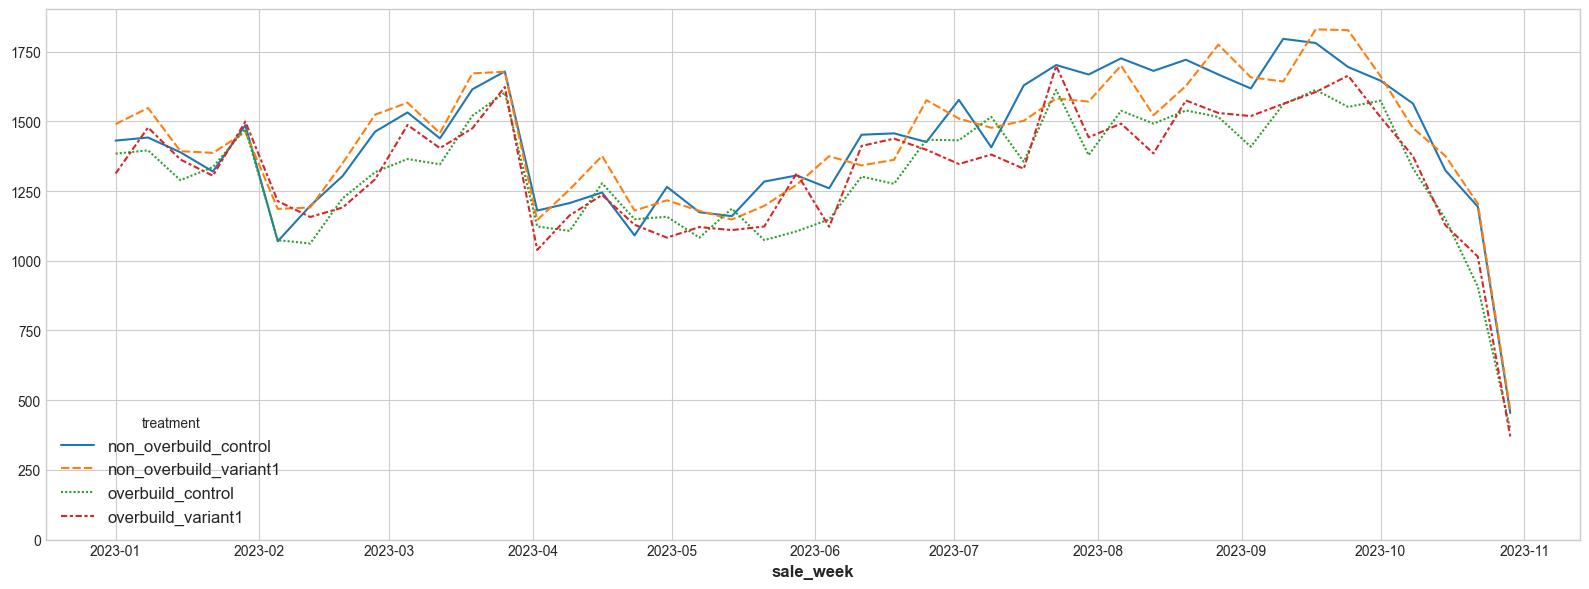

In [9]:
sns.lineplot(data=experiment_by_week_and_treatment)
plt.ylim(0)

# By week, treatment and region

In [10]:
by_week_treatment_region_query = """ 

WITH 
regions AS (

  SELECT 
    postcode, 
    town, 
    local_authority,
    region
  FROM `prj-vo-aa-p-cdh-prod.geography.geography_postcode` 

),

postcodes AS (

    SELECT
        icoms_id.icoms_premises_uid,
        premises_location.postcode,
    FROM
        `prj-vo-aa-p-data-modellin-prod.data_modelling_base.premises_details_base` 

),

sales AS (

SELECT DISTINCT
 
  PARSE_DATE('%Y%m%d', date) AS sale_date,

  (
    SELECT value
    FROM UNNEST(hit.customDimensions)
    WHERE index = 41
  ) AS premise_uid,
  LOWER(product.v2ProductCategory) AS productCategory,

FROM
  `prj-vm-p-ga360-landing.vmdata_ga360_landing.ga_sessions_*` AS session,
  UNNEST(session.hits) AS hit
  LEFT JOIN UNNEST(hit.product) AS product
  LEFT JOIN UNNEST(product.customDimensions) AS customDimensions

WHERE
  _TABLE_SUFFIX BETWEEN '20230101' AND '20231231'
  AND (
    SELECT value
    FROM UNNEST(hit.customDimensions)
    WHERE index = 35
  ) LIKE '%new_cable_order%'
  AND hit.transaction.transactionId is not null 

),

sales_by_week_treatment_region AS (

  SELECT 
    DATE_TRUNC(s.sale_date, WEEK) AS sale_week,
    grp.treatment,
    r.region,
    count(*) AS num_sales

  FROM sales s

    INNER JOIN postcodes p 
    ON s.premise_uid = CAST(p.icoms_premises_uid AS STRING)

    INNER JOIN `prj-vo-aa-p-data-science-exp.m7914180.rnba-1252-postcode-pricing-group-allocations` grp
    ON p.postcode = grp.postcode

    INNER JOIN regions r
    ON p.postcode = r.postcode
  
  GROUP BY 1,2,3

)

SELECT *
FROM sales_by_week_treatment_region
ORDER BY sale_week


"""

experiment_by_week_treatment_region = (bq_client
                                      .query(by_week_treatment_region_query)
                                      .to_dataframe()
                                      .pivot(index='sale_week', columns=['region', 'treatment'], values='num_sales')
                                      )

experiment_by_week_treatment_region.shape

(44, 36)

In [11]:
experiment_by_week_treatment_region = experiment_by_week_treatment_region.sort_values(['region', 'treatment'], axis=1)

In [12]:
experiment_by_week_treatment_region.head()

region            Greater London                                           \
treatment  non_overbuild_control non_overbuild_variant1 overbuild_control   
sale_week                                                                   
2023-01-01                   321                    323               261   
2023-01-08                   298                    278               278   
2023-01-15                   272                    294               303   
2023-01-22                   270                    267               278   
2023-01-29                   287                    321               313   

region                        Home Counties and Anglia                         \
treatment  overbuild_variant1    non_overbuild_control non_overbuild_variant1   
sale_week                                                                       
2023-01-01                247                      172                    137   
2023-01-08                317                      136                    120   
2023-01-15                305                      159                    115   
2023-01-22                320                      131                    136   
2023-01-29                325                      178                    108   

region                                                     North West  \
treatment  overbuild_control overbuild_variant1 non_overbuild_control   
sale_week                                                               
2023-01-01               104                 97                   153   
2023-01-08               105                122                   163   
2023-01-15                70                 85                   107   
2023-01-22                87                 72                   116   
2023-01-29                95                118                   124   

region                             ...     West Midlands                     \
treatment  non_overbuild_variant1  ... overbuild_control overbuild_variant1   
sale_week                          ...                                        
2023-01-01                    136  ...               157                146   
2023-01-08                    166  ...               149                155   
2023-01-15                    158  ...               160                124   
2023-01-22                    145  ...               175                138   
2023-01-29                    145  ...               175                175   

region     Yorkshire and East Midlands                         \
treatment        non_overbuild_control non_overbuild_variant1   
sale_week                                                       
2023-01-01                         231                    293   
2023-01-08                         245                    292   
2023-01-15                         255                    227   
2023-01-22                         216                    261   
2023-01-29                         255                    244   

region                                                            NaN  \
treatment  overbuild_control overbuild_variant1 non_overbuild_control   
sale_week                                                               
2023-01-01               262                278                  <NA>   
2023-01-08               283                301                  <NA>   
2023-01-15               242                275                  <NA>   
2023-01-22               248                245                  <NA>   
2023-01-29               297                293                  <NA>   

region                                                                  
treatment  non_overbuild_variant1 overbuild_control overbuild_variant1  
sale_week                                                               
2023-01-01                   <NA>              <NA>               <NA>  
2023-01-08                   <NA>              <NA>               <NA>  
2023-01-15                   <NA>            

In [13]:
# sns.lineplot(data=experiment_by_week_treatment_region)
# plt.ylim(0)

# Export to Excel

In [14]:
experiment_by_week_treatment_region.to_excel('DRAFT-postcode-pricing-selection-by-treatment-week-region.xlsx', index=True)

In [15]:
experiment_by_week_treatment_region.shape

(44, 36)

# Statistical tests

In [16]:
from scipy.stats import ttest_ind
from scipy.stats import levene

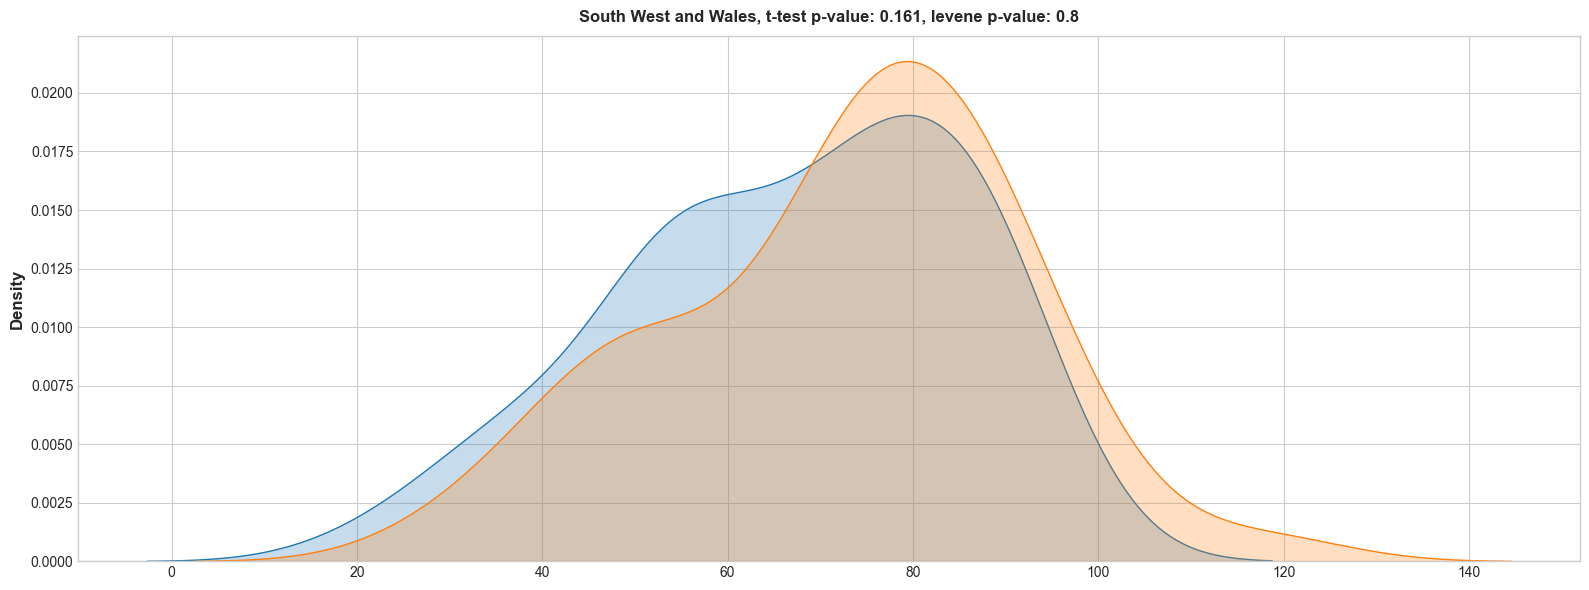

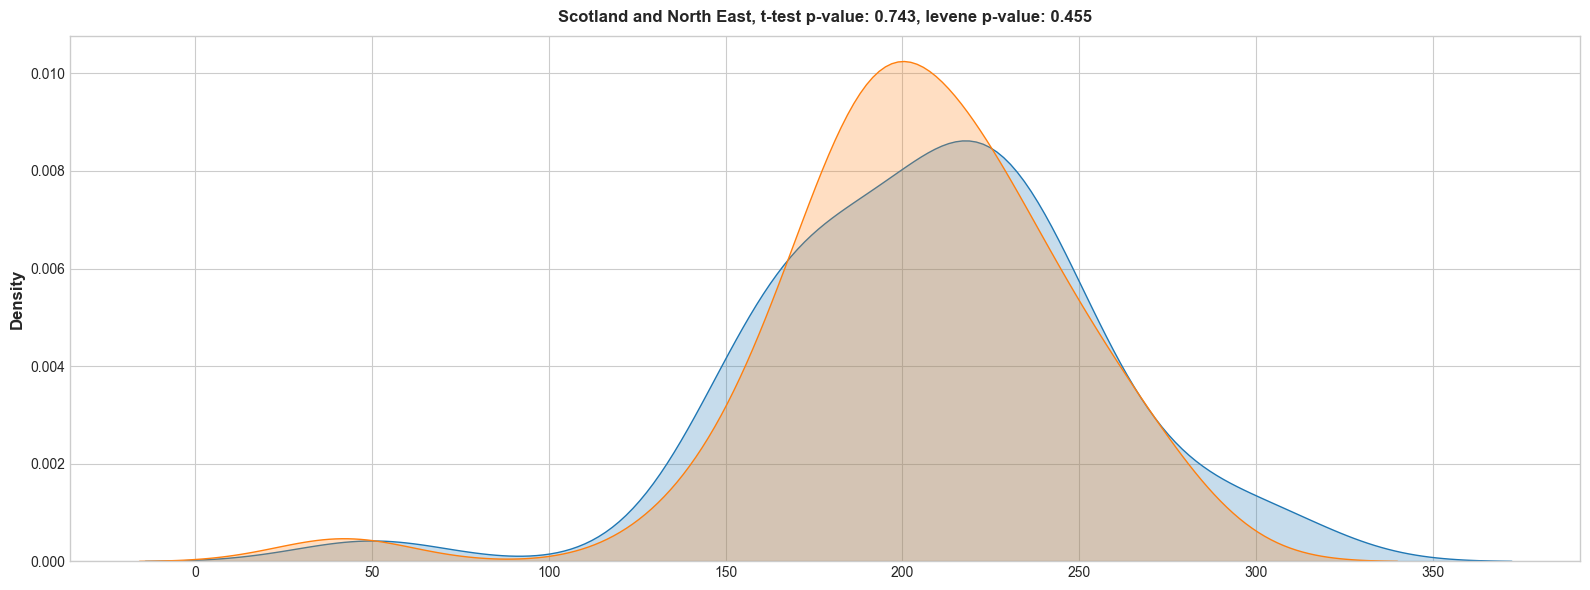

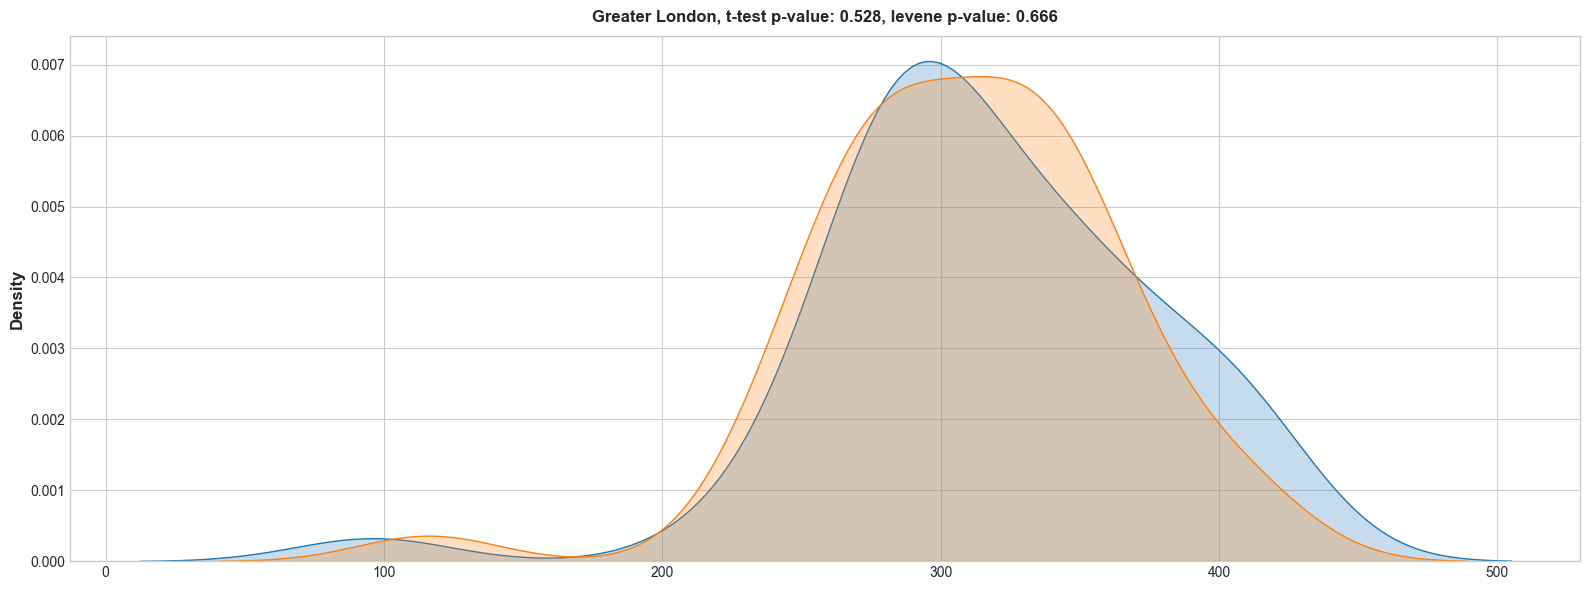

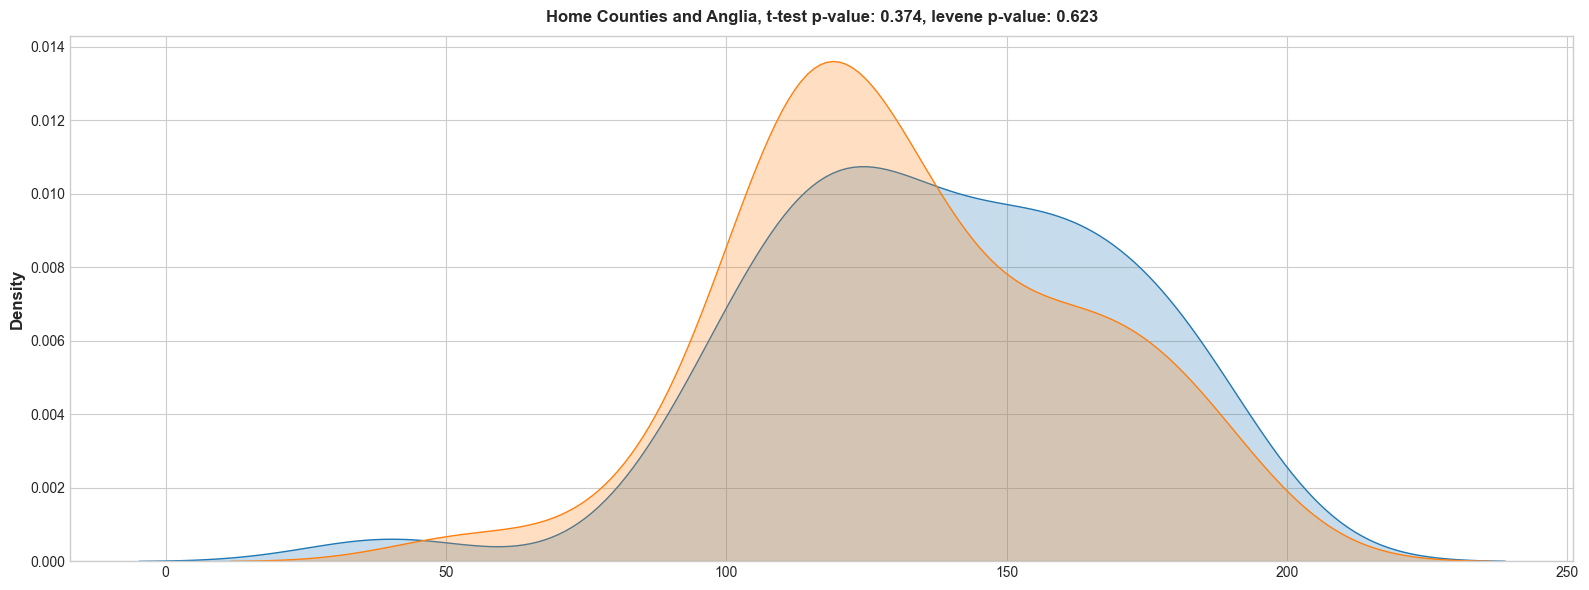

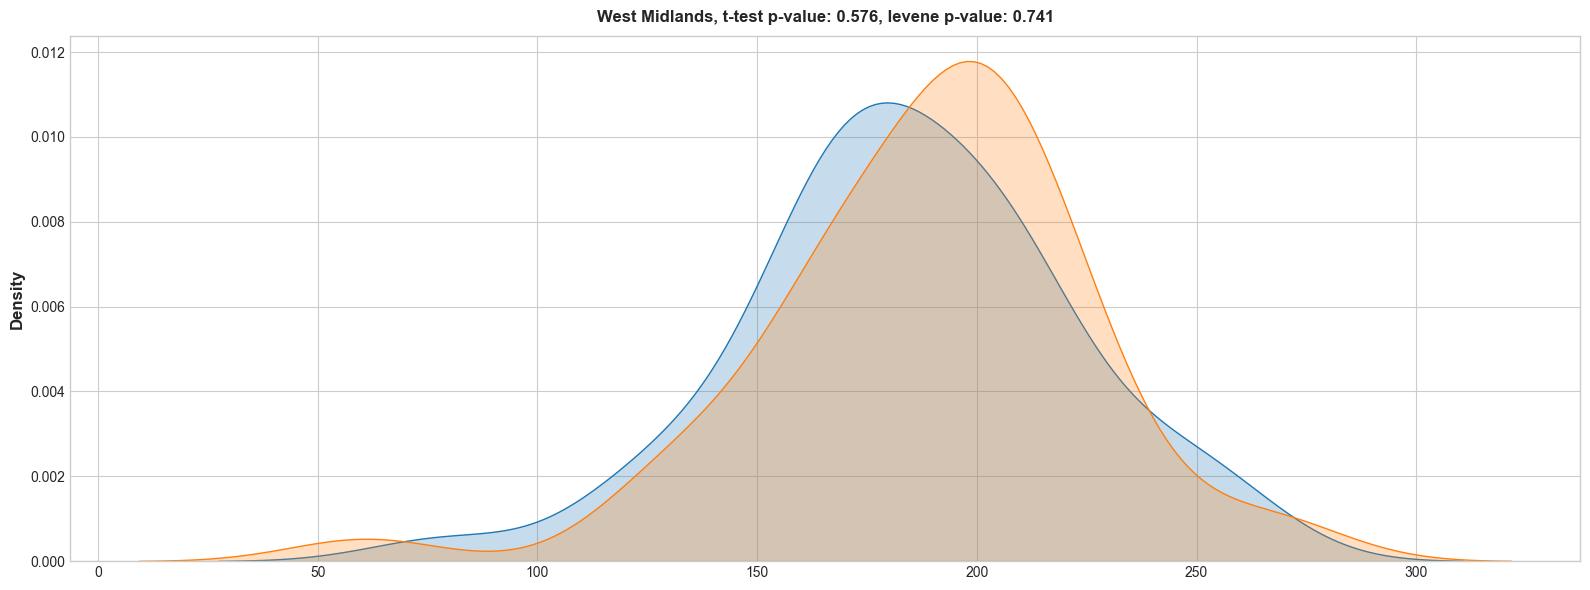

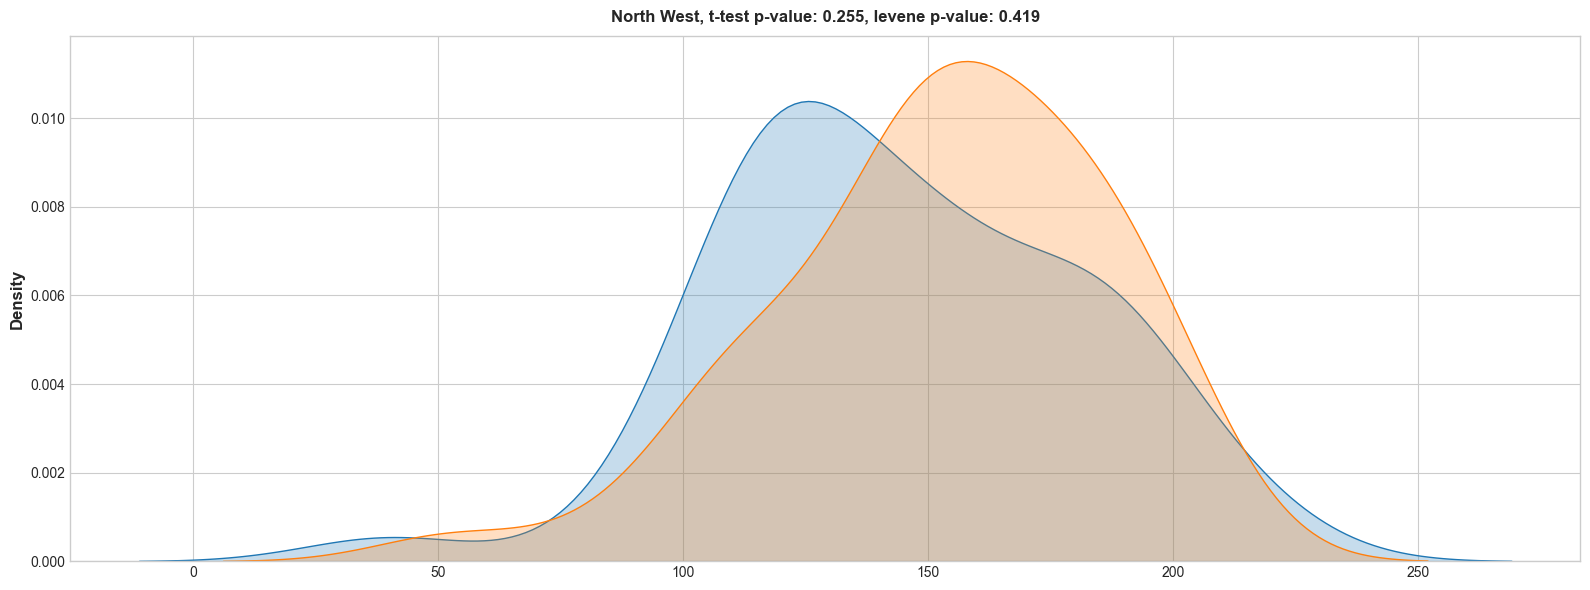

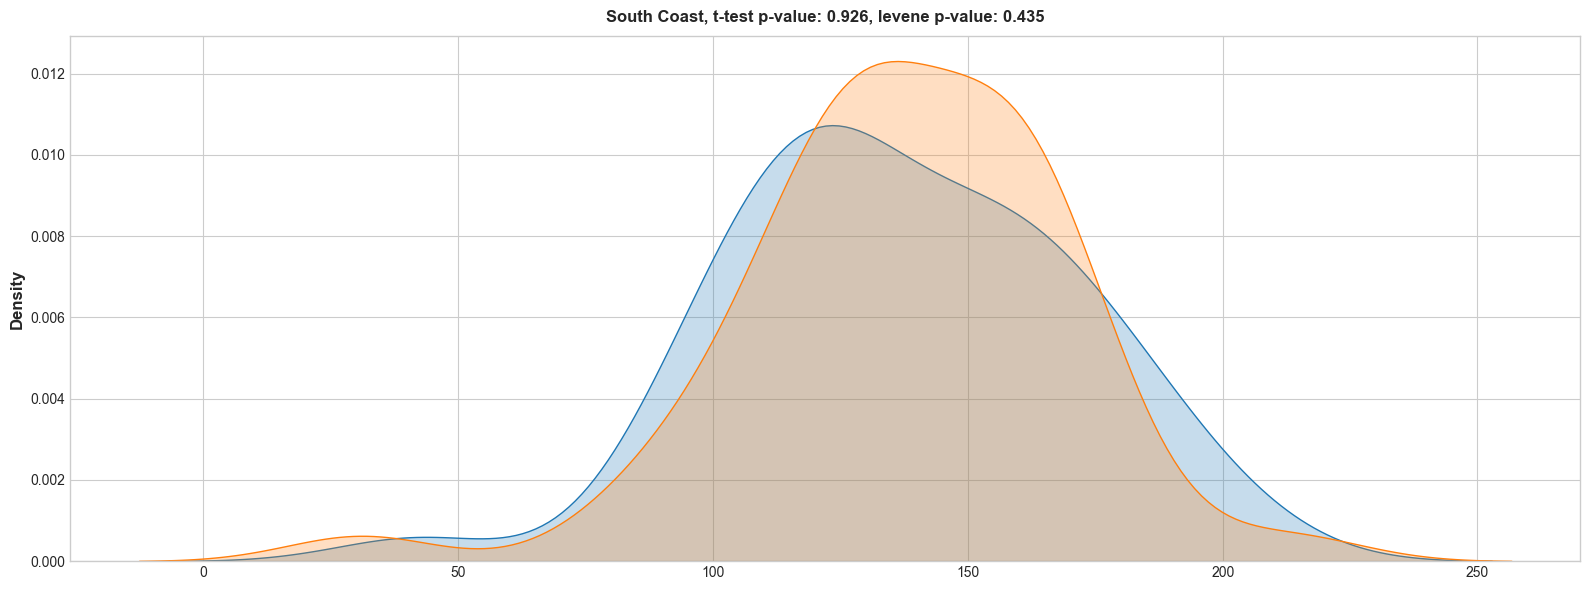

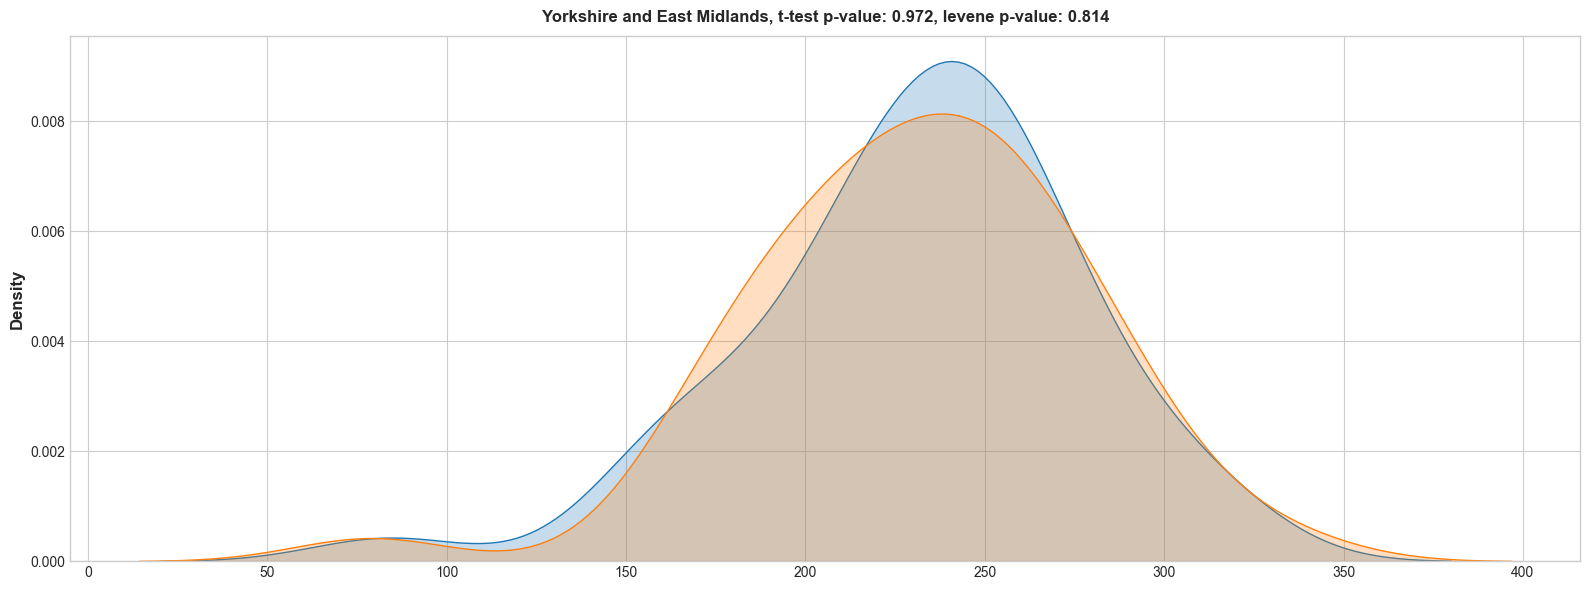

({'South West and Wales': 0.16058571222172704,
  'Scotland and North East': 0.7431073860570778,
  'Greater London': 0.527602223132317,
  'Home Counties and Anglia': 0.3739285580008779,
  'West Midlands': 0.5762949252198273,
  'North West': 0.2548854516956154,
  'South Coast': 0.9262603121544557,
  'Yorkshire and East Midlands': 0.9722052726215973},
 {'South West and Wales': 0.799754669705855,
  'Scotland and North East': 0.4548219227416582,
  'Greater London': 0.6657567626284253,
  'Home Counties and Anglia': 0.6231270423576657,
  'West Midlands': 0.7408054763509095,
  'North West': 0.4188845377480044,
  'South Coast': 0.43516023383899427,
  'Yorkshire and East Midlands': 0.813612076564235})

In [17]:
# I'm hoing that weekly aggregations make independence assumptions close to OK (at least given that the test still suggests independence)

t_test_pvalues = {}  # same mean
levene_pvalues = {}  # same variance
for selected_region in list({region for region, _ in experiment_by_week_treatment_region.columns}):
    if selected_region is np.nan:
        continue

    else:

        df = experiment_by_week_treatment_region[selected_region].fillna(0)

        group1 = list(df.non_overbuild_control.values)
        group2 = list(df.non_overbuild_variant1.values)

        _, t_test_p_val = ttest_ind(group1, group2)
        _, levene_p_value = levene(group1, group2)

        t_test_pvalues[selected_region] = t_test_p_val
        levene_pvalues[selected_region] = levene_p_value

        sns.kdeplot(data=group1, fill=True)
        sns.kdeplot(data=group2, fill=True)
        plt.title(f"{selected_region}, t-test p-value: {t_test_p_val:0.3}, levene p-value: {levene_p_value:0.3}")
        plt.show()

t_test_pvalues, levene_pvalues

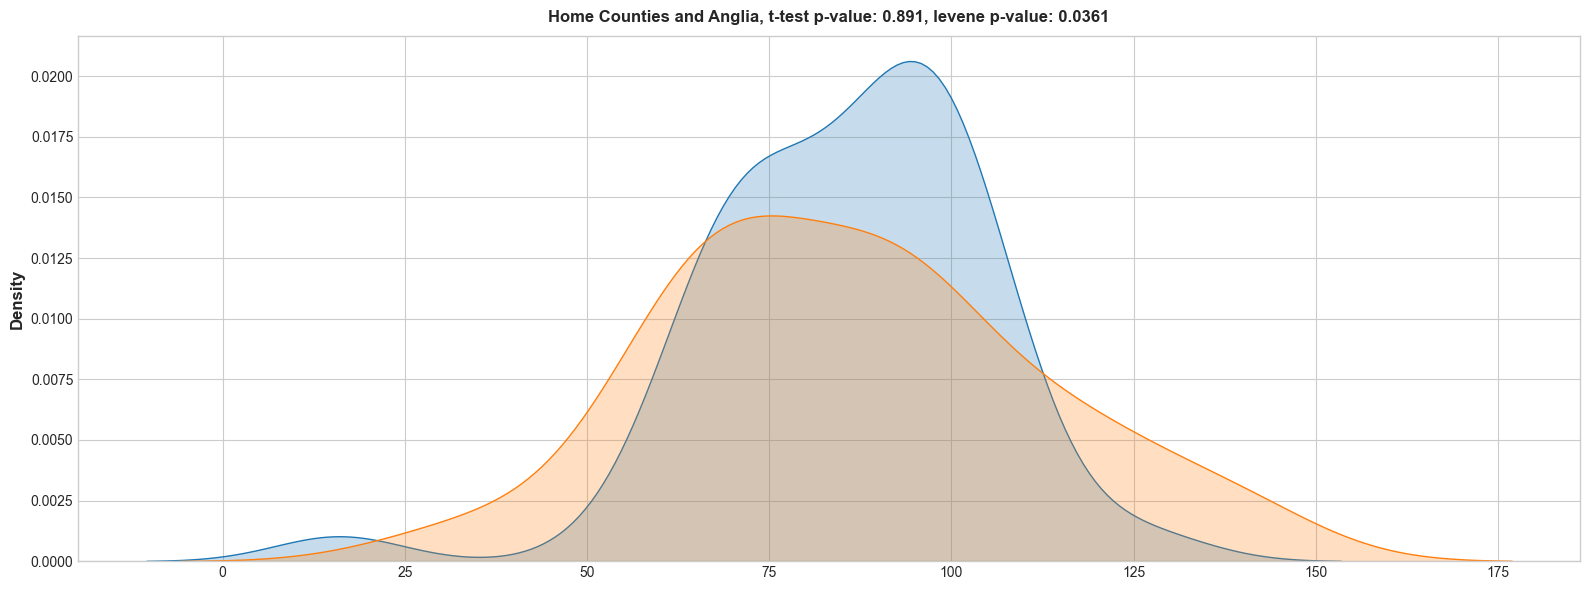

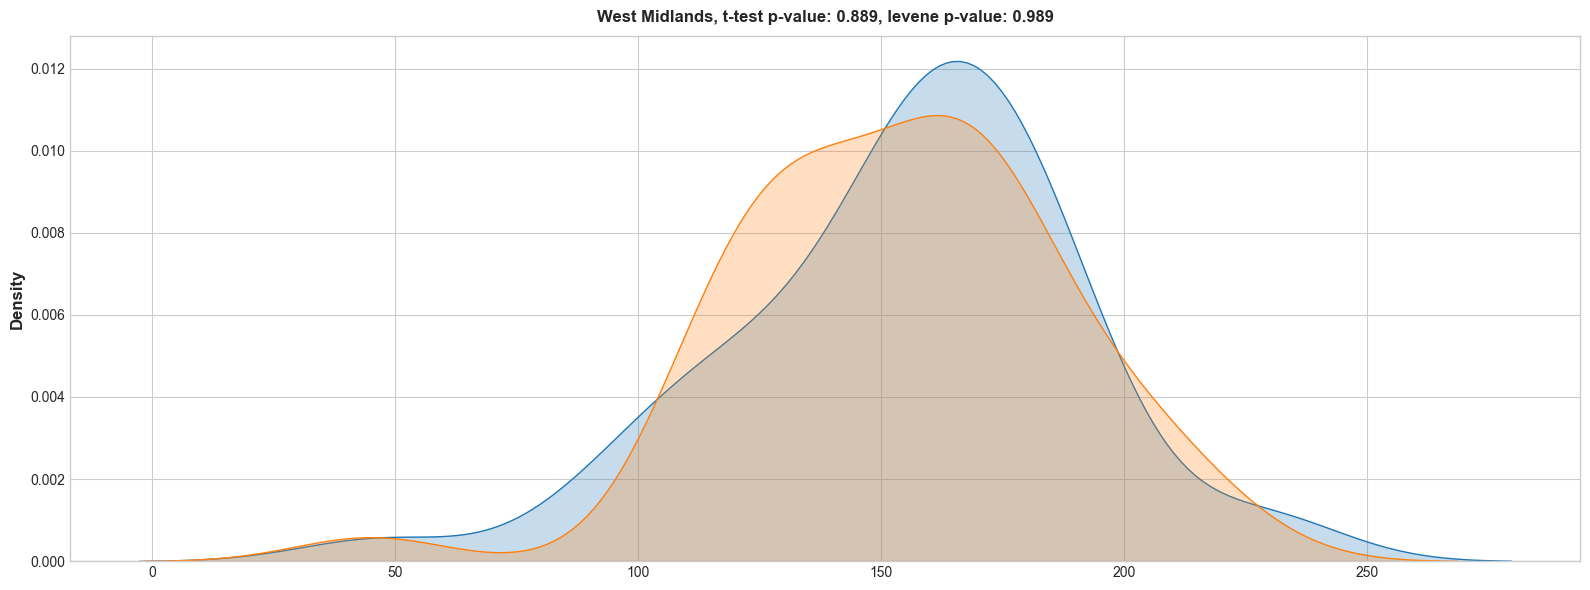

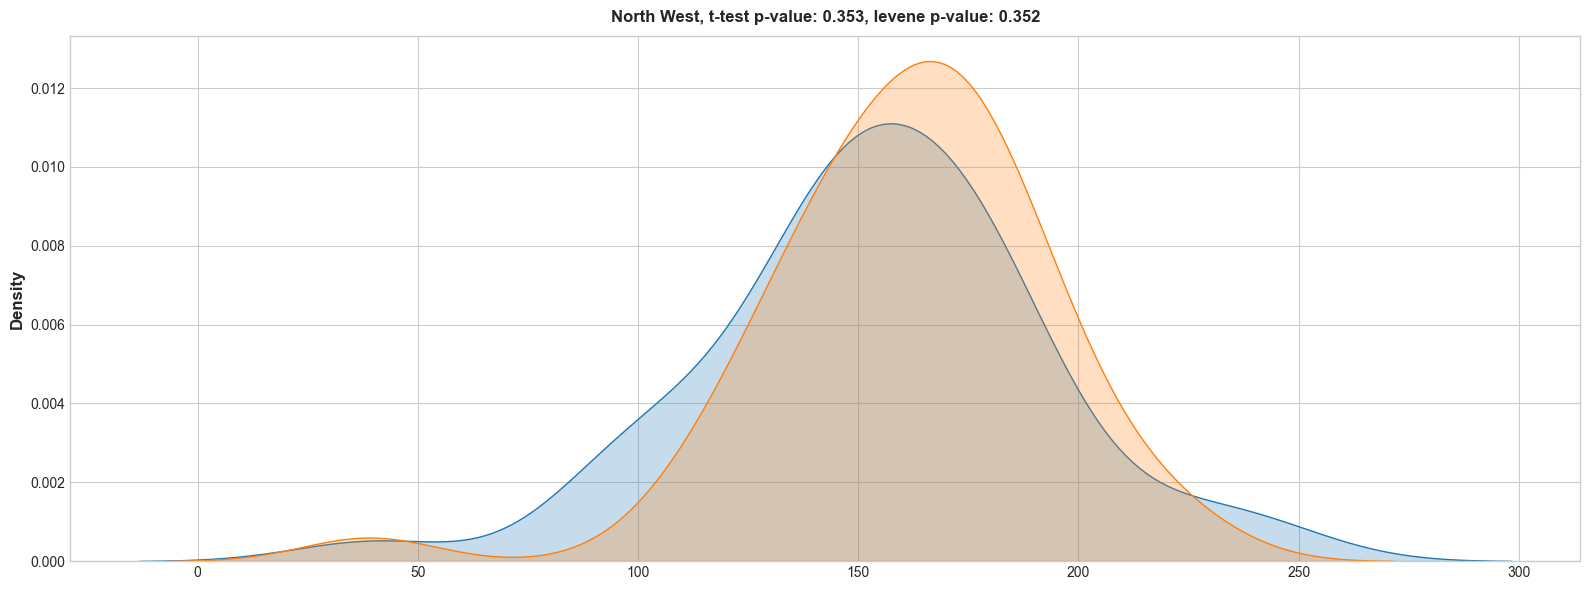

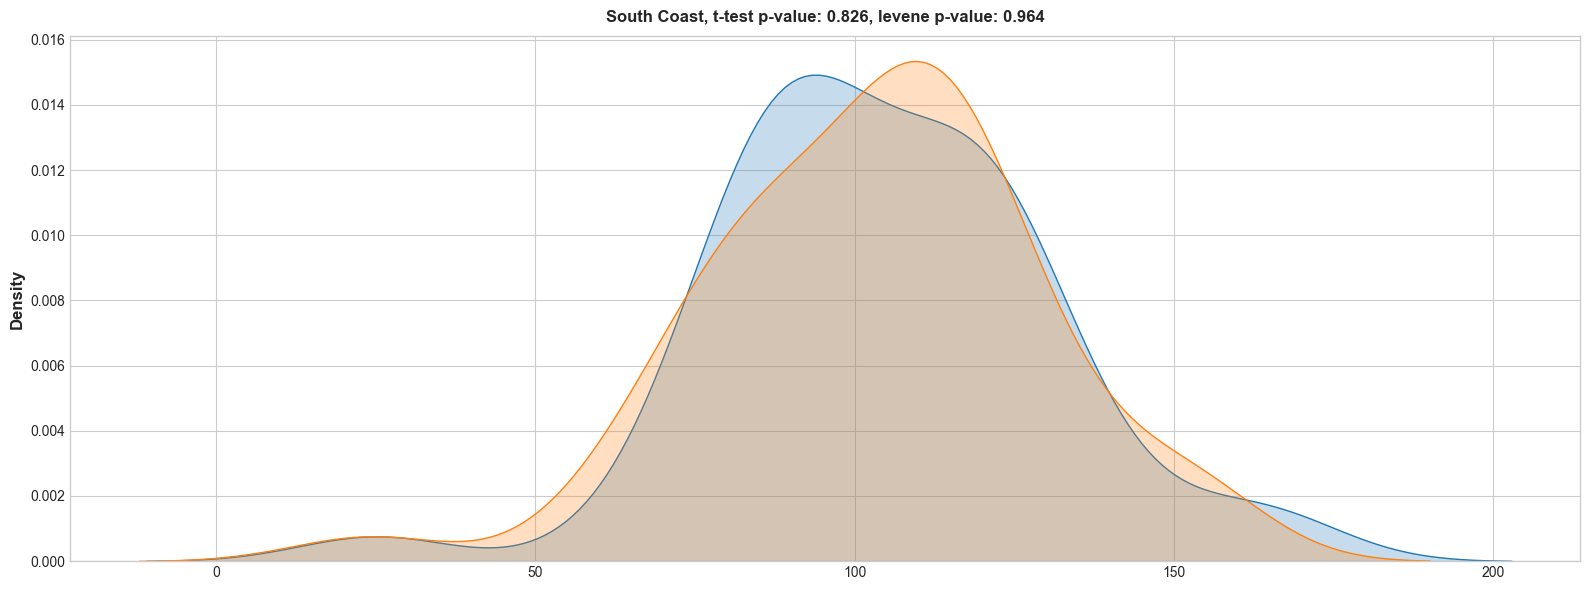

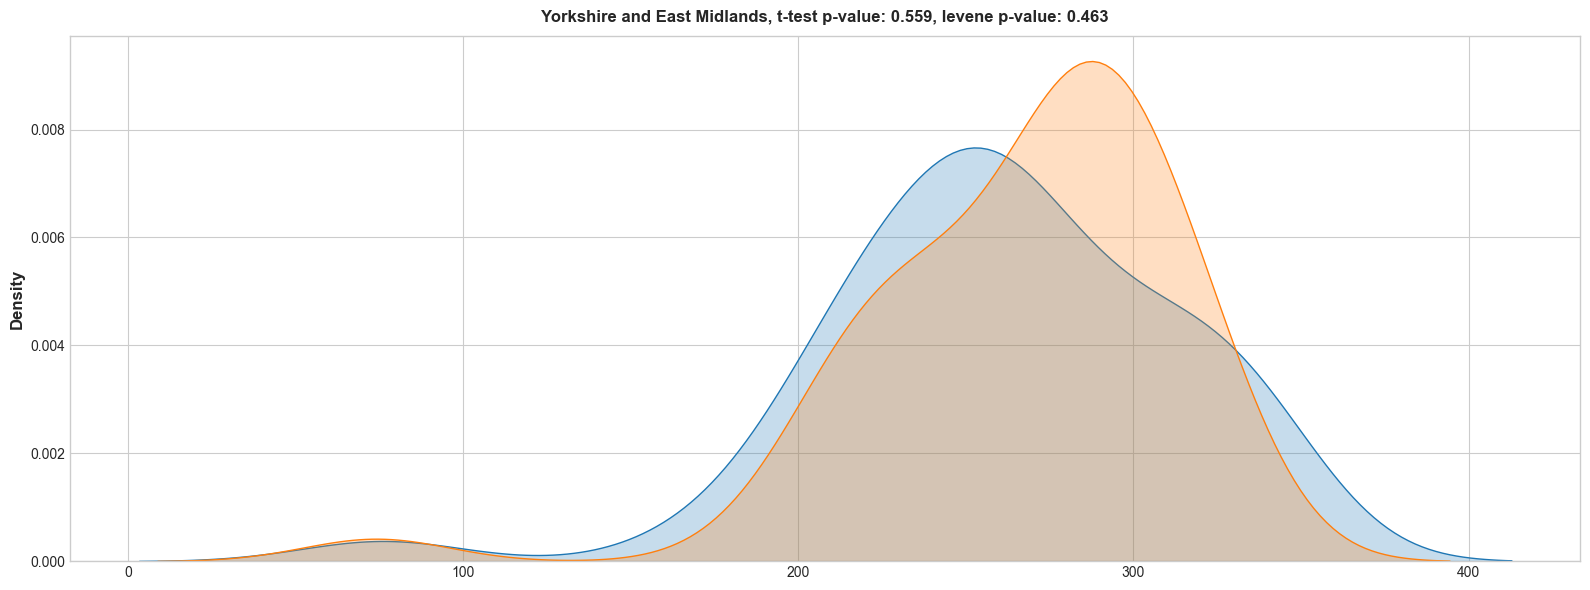

({'South West and Wales': 0.526165597495812,
  'Scotland and North East': 0.7857042335626767,
  'Greater London': 0.5167703005765685,
  'Home Counties and Anglia': 0.8905676219986298,
  'West Midlands': 0.88884884289182,
  'North West': 0.35305722100252546,
  'South Coast': 0.8257861603149865,
  'Yorkshire and East Midlands': 0.559465426102115},
 {'South West and Wales': 0.32145860676679805,
  'Scotland and North East': 0.8147887521404643,
  'Greater London': 0.49561616267478725,
  'Home Counties and Anglia': 0.03609468017030093,
  'West Midlands': 0.9886447472181324,
  'North West': 0.3520048327154923,
  'South Coast': 0.9638406588643177,
  'Yorkshire and East Midlands': 0.4634284245634678})

In [18]:
t_test_pvalues = {}  # same mean
levene_pvalues = {}  # same variance
for selected_region in list({region for region, _ in experiment_by_week_treatment_region.columns}):
    if selected_region is np.nan:
        continue

    else:

        df = experiment_by_week_treatment_region[selected_region].fillna(0)

        group1 = list(df.overbuild_control.values)
        group2 = list(df.overbuild_variant1.values)

        _, t_test_p_val = ttest_ind(group1, group2)
        _, levene_p_value = levene(group1, group2)

        t_test_pvalues[selected_region] = t_test_p_val
        levene_pvalues[selected_region] = levene_p_value

        sns.kdeplot(data=group1, fill=True)
        sns.kdeplot(data=group2, fill=True)
        plt.title(f"{selected_region}, t-test p-value: {t_test_p_val:0.3}, levene p-value: {levene_p_value:0.3}")
        plt.show()

t_test_pvalues, levene_pvalues

# Inspect the time series

In [19]:
import random

Text(0.5, 1.0, 'Yorkshire and East Midlands')

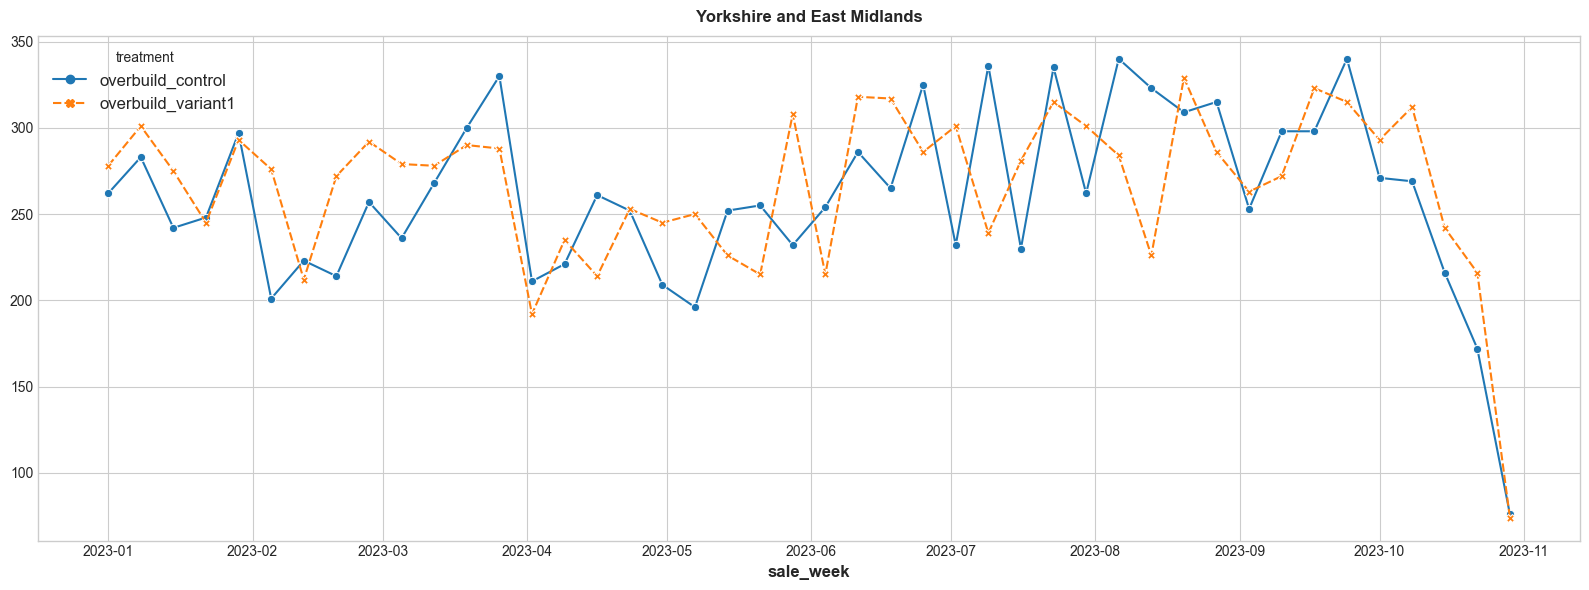

In [20]:
selected_region = random.choice(list({region for region, _ in experiment_by_week_treatment_region.columns}))

sns.lineplot(data=experiment_by_week_treatment_region.loc(1)[selected_region].filter(regex='^overbuild'), markers=True)
plt.title(selected_region)